In [1]:
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

## Load in the dataset CSV

In [2]:
df = pd.read_csv("../input_data/butterfly_anomaly_train.csv")
df.head()

,f,file_url,hybrid_stat,split,zenodo_link,md5,subspecies,parent_subspecies_1,parent_subspecies_2,filename,classification
0,CAM017821,https://zenodo.org/record/1748277/files/CAM017...,hybrid,train,https://zenodo.org/record/1748277,ba38c61337e2d720f5f72451387d4a48,NaN,8.0,9.0,CAM017821.jpg,8.0 and 9.0
1,CAM017820,https://zenodo.org/record/1748277/files/CAM017...,hybrid,train,https://zenodo.org/record/1748277,9a2ff257a0ad17055eae3cc6c279a62b,NaN,8.0,9.0,CAM017820.jpg,8.0 and 9.0
2,CAM017693,https://zenodo.org/record/1748277/files/CAM017...,hybrid,train,https://zenodo.org/record/1748277,c314eec15bb53750bdd68595d95a5e93,NaN,8.0,9.0,CAM017693.jpg,8.0 and 9.0
3,CAM018291,https://zenodo.org/record/2548678/files/CAM018...,non-hybrid,train,https://zenodo.org/record/2548678,e3a7bf83bdb9f11c035873a623a31345,8.0,NaN,NaN,CAM018291.jpg,8
4,CAM011430,https://zenodo.org/record/2550097/files/CAM011...,non-hybrid,train,https://zenodo.org/record/2550097,5060c653aea379c72802aa3ef8af32b0,9.0,NaN,NaN,CAM011430.jpg,9


## Make one column with classification

This is the subspecies (which may is a mix of two for some specimens, the hybrids); this is for coloring the distribution plot by hybrid status and showing all together.

In [3]:
# camid: class activation map id
for camid in list(df.loc[df["subspecies"].isna(), "CAMID"]):
    temp = df.loc[df["CAMID"] == camid]
    subspecies = temp["parent_subspecies_1"].astype(str) + " and " + temp["parent_subspecies_2"].astype(str)
    df.loc[df["CAMID"] == camid, "classification"] = subspecies
for camid in list(df.loc[df["subspecies"].notna(), "CAMID"]):
    temp = df.loc[df["CAMID"] == camid]
    subspecies = temp["subspecies"].astype(str)
    df.loc[df["CAMID"] == camid, "classification"] = subspecies

KeyError: 'CAMID'

In [5]:
df.head()

,CAMID,file_url,hybrid_stat,split,zenodo_link,md5,subspecies,parent_subspecies_1,parent_subspecies_2,filename,classification
0,CAM017821,https://zenodo.org/record/1748277/files/CAM017...,hybrid,train,https://zenodo.org/record/1748277,ba38c61337e2d720f5f72451387d4a48,NaN,8.0,9.0,CAM017821.jpg,8.0 and 9.0
1,CAM017820,https://zenodo.org/record/1748277/files/CAM017...,hybrid,train,https://zenodo.org/record/1748277,9a2ff257a0ad17055eae3cc6c279a62b,NaN,8.0,9.0,CAM017820.jpg,8.0 and 9.0
2,CAM017693,https://zenodo.org/record/1748277/files/CAM017...,hybrid,train,https://zenodo.org/record/1748277,c314eec15bb53750bdd68595d95a5e93,NaN,8.0,9.0,CAM017693.jpg,8.0 and 9.0
3,CAM018291,https://zenodo.org/record/2548678/files/CAM018...,non-hybrid,train,https://zenodo.org/record/2548678,e3a7bf83bdb9f11c035873a623a31345,8.0,NaN,NaN,CAM018291.jpg,8.0
4,CAM011430,https://zenodo.org/record/2550097/files/CAM011...,non-hybrid,train,https://zenodo.org/record/2550097,5060c653aea379c72802aa3ef8af32b0,9.0,NaN,NaN,CAM011430.jpg,9.0


## Get distribution of images by subspecies (colored by hybrid status)

<Axes: xlabel='Count', ylabel='classification'>

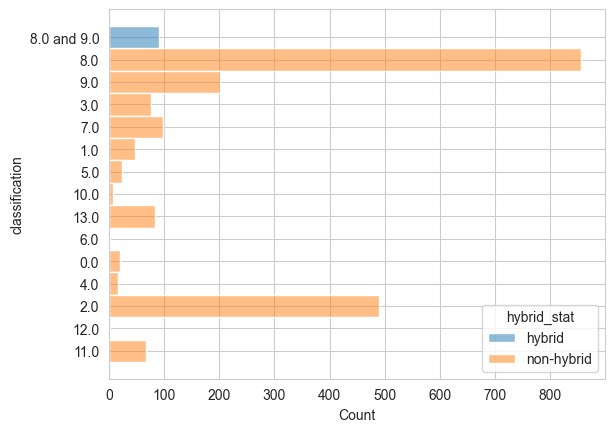

In [6]:
sns.histplot(df, y = "classification", hue = "hybrid_stat")

## Start here

## Import training requirements

In [1]:
import torch
import sys
import os
import csv
from pathlib import Path
# Add your path of library
sys.path.append('../DINO_train')
import training

## Load Training Data

In [2]:
# TODO: Change to the correct path for your .csv file (butterfly_anomaly_train.csv)
training.DATA_FILE = Path('../input_data/butterfly_anomaly_train.csv')
# training.IMG_DIR = Path('./sample_images')
# TODO: Change to the correct path for your images
training.IMG_DIR = Path('../input_data/both')
train_data, test_data = training.load_data(training.DATA_FILE, training.IMG_DIR)
print(train_data.shape)

Filtering bad urls: 12082it [00:16, 726.98it/s]

Bad rows: 0
(9665, 11)


## Model setup


In [3]:
training.DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
model = training.get_dino_model(dino_name='facebook/dinov2-base').to(training.DEVICE)
training.BATCH_SIZE = 4

# Location to save checkpoints and results
training.CLF_SAVE_DIR = Path('./trained_clfs')
os.makedirs(training.CLF_SAVE_DIR, exist_ok=True)
print(training.DEVICE)
# print(model)
print(type(model))


cpu
<class 'transformers.models.dinov2.modeling_dinov2.Dinov2Model'>


## Start training

In [4]:
# Create dataloader
tr_sig_dloader, test_dl = training.prepare_data_loaders(train_data, test_data)
print(tr_sig_dloader)
print(test_dl)

Created base dataset with 9665 samples
Created base dataset with 2417 samples


In [22]:
# Extract visual features from model
try: 
    tr_features, tr_labels, test_features, test_labels = training.extract_features(tr_sig_dloader, test_dl, model)
    print(tr_features)
except Exception as e:
    print("Error in extracting features")
    print(e)

Extracting features:   0%|          | 2/2417 [00:36<10:33:57, 15.75s/it]

In [25]:
print(tr_features)

[[ 0.07480468  1.0148212  -0.44328105 ... -1.3911552  -0.78655094
  -0.7207247 ]
 [-2.799437    1.1824923  -2.1693401  ... -1.4877348  -1.2589675
  -0.4212661 ]
 [-1.6104      0.00404462 -2.7286115  ... -0.66142565 -0.59261125
  -0.61701185]
 ...
 [-3.4467356   0.54792047 -1.8496662  ... -1.0453129  -1.5139419
  -0.4645679 ]
 [-2.593028    1.152011   -2.428368   ... -1.0441059  -1.797775
  -0.37309414]
 [-3.5681794   0.9330046  -1.8699456  ... -1.5799365  -1.3101511
  -0.8292255 ]]


In [26]:
# Train classifier with visual features
csv_output, score_output = training.train_and_evaluate(tr_features, tr_labels, test_features, test_labels)

Training and evaluating svm...
Saved svm classifier to trained_clfs\trained_svm_classifier.pkl
svm: Acc - 0.9730, Hacc - 0.9444, NHacc - 0.9746

          Hybrid-Recall: 1.0
          Hybrid-Precision: 0.4117647058823529
          f1-Score: 0.5833333333333334
          ROC AUC: 0.9751861042183623
          Accuracy: 0.9520383693045563
          
Training and evaluating sgd...
Saved sgd classifier to trained_clfs\trained_sgd_classifier.pkl
sgd: Acc - 0.9790, Hacc - 0.6111, NHacc - 1.0000

          Hybrid-Recall: 1.0
          Hybrid-Precision: 0.4117647058823529
          f1-Score: 0.5833333333333334
          ROC AUC: 0.9751861042183623
          Accuracy: 0.9520383693045563
          
Training and evaluating knn...
Saved knn classifier to trained_clfs\trained_knn_classifier.pkl
knn: Acc - 0.9820, Hacc - 0.6667, NHacc - 1.0000

          Hybrid-Recall: 1.0
          Hybrid-Precision: 0.4117647058823529
          f1-Score: 0.5833333333333334
          ROC AUC: 0.9751861042183623
      

In [24]:
# Save evaluation results
csv_filename = training.CLF_SAVE_DIR / "classifier_evaluation_results.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Configuration", "AUC", "Precision", "Recall", "F1-score"])
    writer.writerows(csv_output)

# Save individual scores
scores_filename = training.CLF_SAVE_DIR / "classifier_scores.csv"
with open(scores_filename, mode='w', newline='') as score_file:
    score_writer = csv.writer(score_file)
    score_writer.writerow(["Index", "Score", "True Label"])
    score_writer.writerows(score_output)